## Brain Tumor Image

### 01 Data input

In [19]:
import json
from collections import Counter

path = r".\train\_annotations.coco.json"
with open(path, "r", encoding="utf-8") as f:
    data = json.load(f)

print("images:", len(data.get("images", [])))
print("annotations:", len(data.get("annotations", [])))
print("categories:", len(data.get("categories", [])))
print("category names:", [c.get("name") for c in data.get("categories", [])])

# example: annotation counts per category id
cat_counts = Counter(a["category_id"] for a in data.get("annotations", []))
print("annotations per category id:", dict(cat_counts))

images: 1502
annotations: 1502
categories: 3
category names: ['Tumor', '0', '1']
annotations per category id: {1: 771, 2: 731}


成功匯入 PIL (Pillow)。將使用 PIL 進行圖片處理。
--- 程式碼開始 ---
正在嘗試載入 JSON 檔案: ./train/_annotations.coco.json
JSON 檔案載入成功。
找到 1502 張圖片的紀錄。
找到 1501 張有標註的圖片。

--- 沒有標註的圖片 (Image IDs) ---
共 1 張:
[1380]

--- 有多個標註的圖片 (Image IDs) ---
共 1 張:
[1005]

--- 隨機顯示 3 張範例圖片 ---
將顯示 Image IDs: [664, 913, 446]

已儲存範例圖片至 annotation_analysis_samples_bw_mask.png
--- 程式碼執行完畢 ---


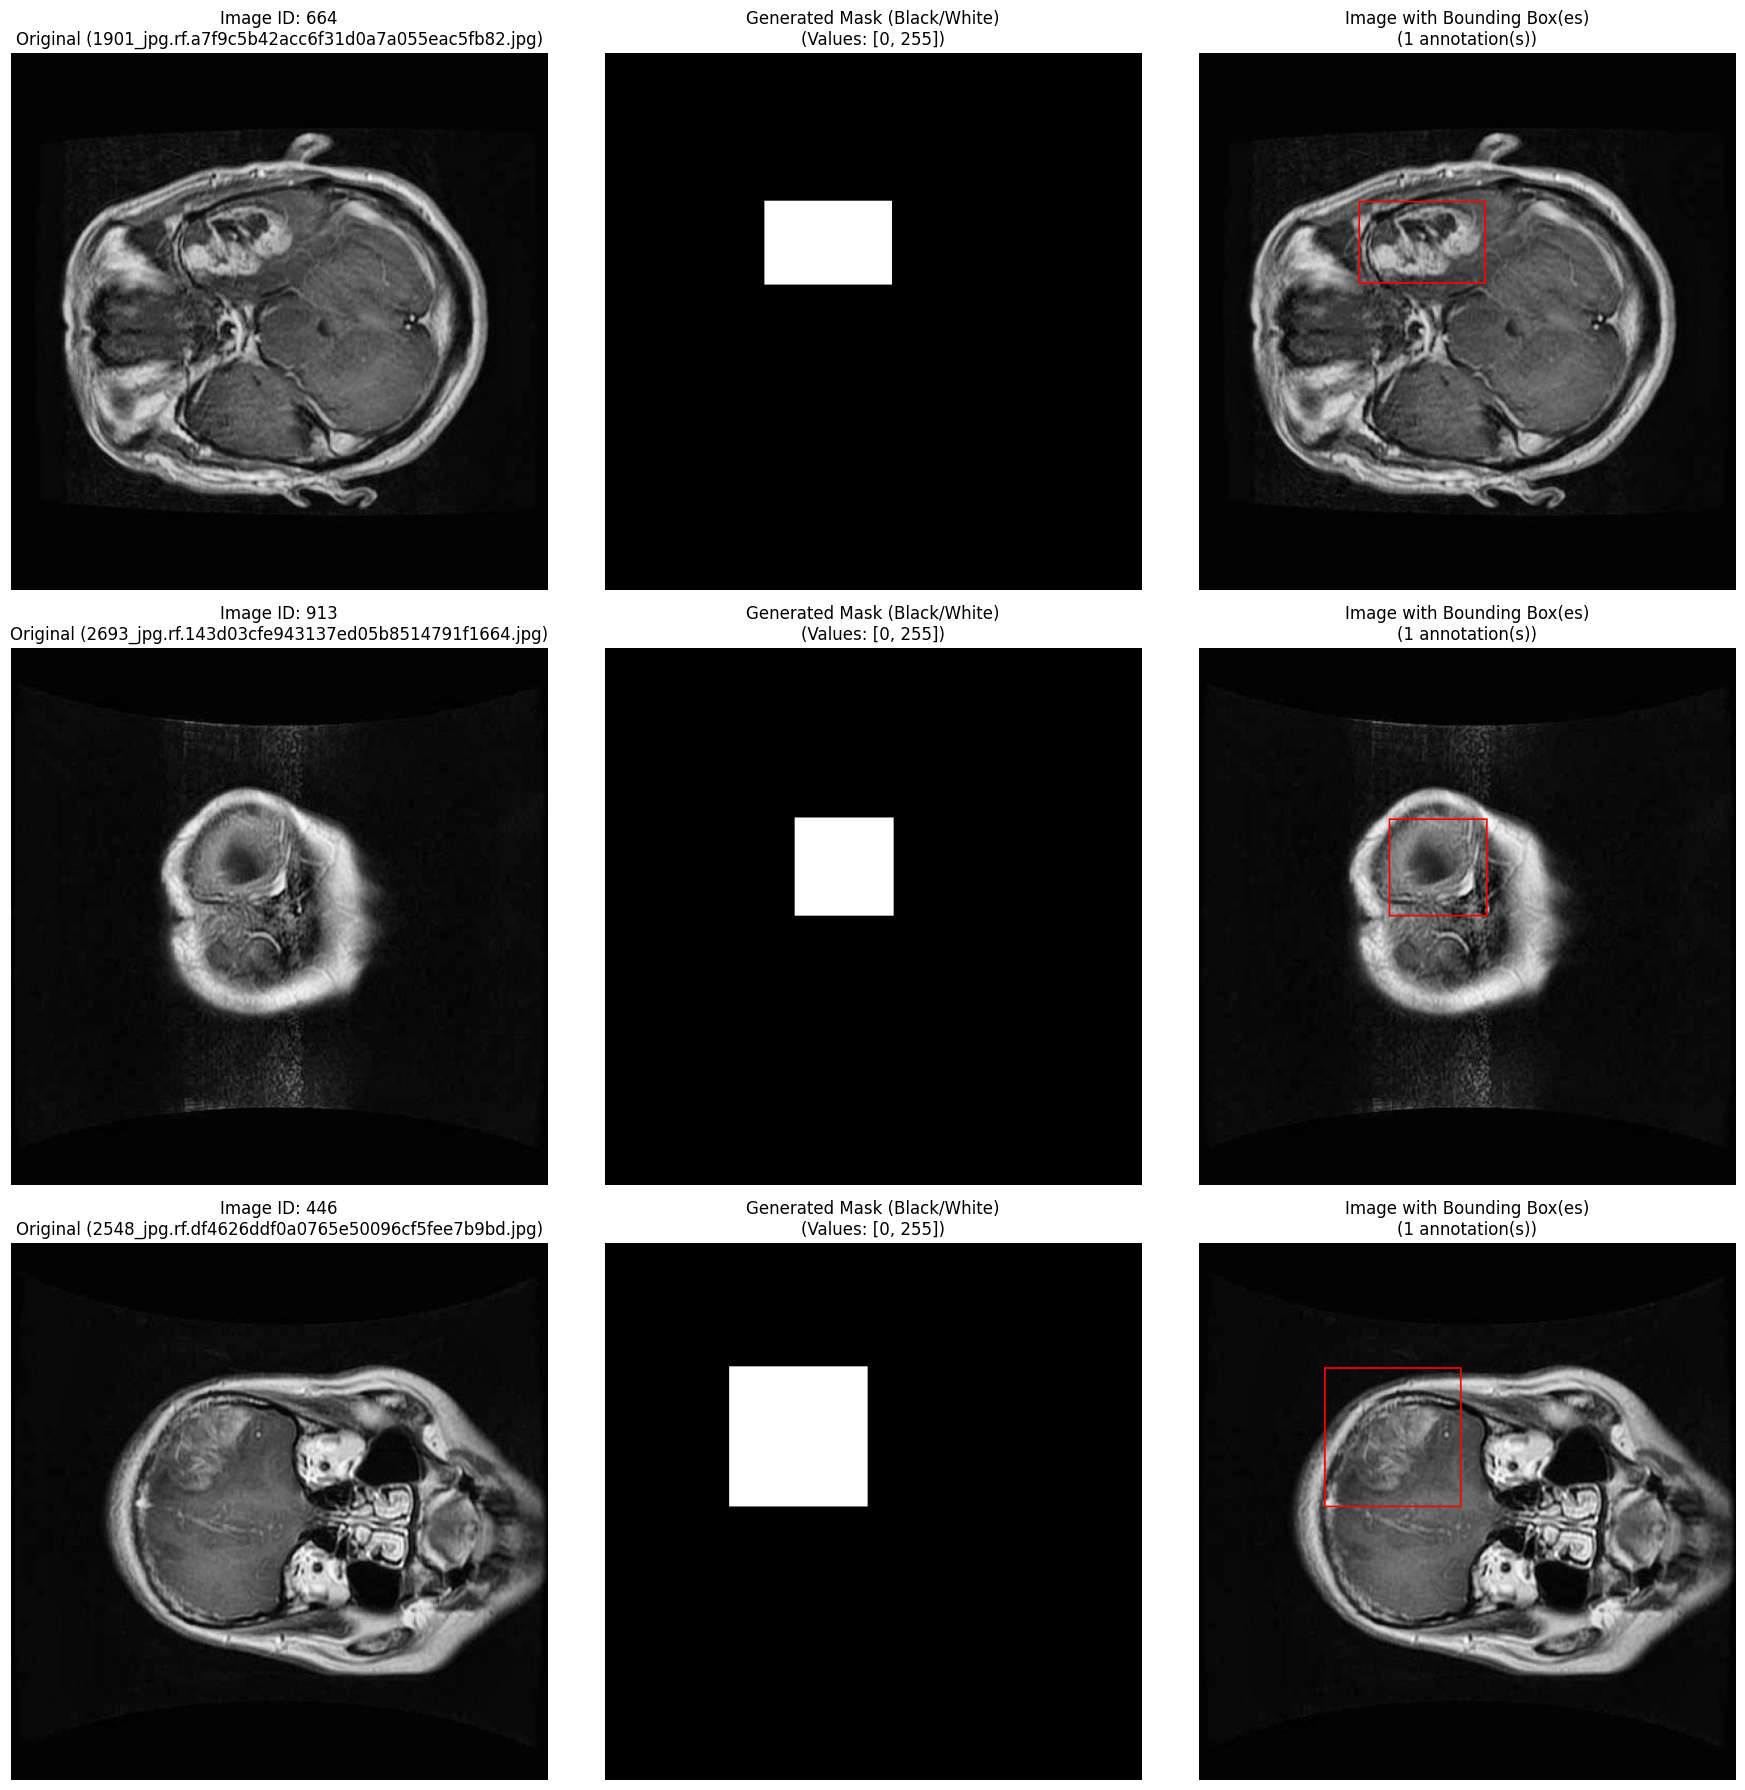

In [20]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict

# 匯入 PIL (Pillow) 函式庫，用於圖片處理
try:
    from PIL import Image, ImageDraw
    print("成功匯入 PIL (Pillow)。將使用 PIL 進行圖片處理。")
except ImportError:
    print("錯誤：無法匯入 PIL。無法繼續進行圖片處理。")
    raise

# --- 設定 ---
json_path = "./train/_annotations.coco.json"
image_base_dir = "./train"
num_samples_to_show = 3

print(f"--- 程式碼開始 ---")

try:
    # --- 1. 載入 JSON 檔案 ---
    print(f"正在嘗試載入 JSON 檔案: {json_path}")
    if not os.path.exists(json_path):
        print(f"錯誤：找不到 JSON 檔案 '{json_path}'。")
        print("請上傳此檔案後再試一次。")
        raise FileNotFoundError(f"找不到檔案: {json_path}")
        
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    print("JSON 檔案載入成功。")

    # --- 2. 處理圖像和標註 ---
    all_image_ids = set()
    image_id_to_file = {}
    if 'images' in data:
        for img in data['images']:
            all_image_ids.add(img['id'])
            image_id_to_file[img['id']] = img['file_name']
    print(f"找到 {len(all_image_ids)} 張圖片的紀錄。")

    image_id_to_annotations = defaultdict(list)
    if 'annotations' in data:
        for ann in data['annotations']:
            image_id_to_annotations[ann['image_id']].append(ann)
    print(f"找到 {len(image_id_to_annotations)} 張有標註的圖片。")

    # --- 3. 找出沒有標註的圖片 ---
    annotated_image_ids = set(image_id_to_annotations.keys())
    unannotated_image_ids = all_image_ids - annotated_image_ids
    
    print("\n--- 沒有標註的圖片 (Image IDs) ---")
    if unannotated_image_ids:
        print(f"共 {len(unannotated_image_ids)} 張:")
        print(list(unannotated_image_ids))
    else:
        print("所有圖片都有標註。")

    # --- 4. 找出有多個標註的圖片 ---
    multiple_annotated_image_ids = {img_id for img_id, annos in image_id_to_annotations.items() if len(annos) > 1}
            
    print("\n--- 有多個標註的圖片 (Image IDs) ---")
    if multiple_annotated_image_ids:
        print(f"共 {len(multiple_annotated_image_ids)} 張:")
        print(list(multiple_annotated_image_ids)[:50])
        if len(multiple_annotated_image_ids) > 50:
            print(f"... (還有 {len(multiple_annotated_image_ids) - 50} 個)")
    else:
        print("沒有圖片有多於一個標註。")

    # --- 5. 隨機挑選 {num_samples_to_show} 張有標註的圖片顯示 ---
    print(f"\n--- 隨機顯示 {num_samples_to_show} 張範例圖片 ---")
    
    annotated_image_id_list = list(annotated_image_ids)
    
    if not annotated_image_id_list:
        print("沒有可顯示的有標註圖片。")
    else:
        num_to_sample = min(num_samples_to_show, len(annotated_image_id_list))
        if num_to_sample < num_samples_to_show:
            print(f"警告：有標註的圖片少於 {num_samples_to_show} 張，僅顯示 {num_to_sample} 張。")
            
        sample_image_ids = random.sample(annotated_image_id_list, num_to_sample)
        print(f"將顯示 Image IDs: {sample_image_ids}")

        fig, axes = plt.subplots(num_to_sample, 3, figsize=(18, 6 * num_to_sample))
        if num_to_sample == 1:
            axes = np.array([axes])

        for i, sample_image_id in enumerate(sample_image_ids):
            try:
                file_name = image_id_to_file[sample_image_id]
                image_path = os.path.join(image_base_dir, file_name)
                
                if not os.path.exists(image_path):
                    print(f"錯誤：找不到圖片檔案 {image_path}")
                    axes[i, 0].set_title(f"Image ID {sample_image_id}\nFile Not Found: {file_name}", color='red')
                    axes[i, 0].axis('off')
                    axes[i, 1].axis('off')
                    axes[i, 2].axis('off')
                    continue

                # 使用 PIL 載入圖片
                image = Image.open(image_path).convert("RGB")
                
                # 準備 Mask (使用 PIL)
                # 'L' mode for 8-bit grayscale mask (0 = 黑色)
                mask_pil = Image.new("L", image.size, 0)
                mask_draw = ImageDraw.Draw(mask_pil)
                
                # 準備 Bounding Box 圖片 (使用 PIL)
                image_with_box = image.copy()
                box_draw = ImageDraw.Draw(image_with_box)
                
                mask_values = {0} # 0 代表背景 (黑色)
                
                annotations = image_id_to_annotations[sample_image_id]
                
                for ann in annotations:
                    # 繪製 Bounding Box
                    if 'bbox' in ann:
                        bbox = ann['bbox'] # [x, y, w, h]
                        x, y, w, h = map(int, bbox)
                        box_draw.rectangle([x, y, x + w, y + h], outline="red", width=2)

                    # 繪製 Segmentation Mask
                    if 'segmentation' in ann:
                        segmentation = ann['segmentation']
                        for poly in segmentation:
                            # *** 修改：將 fill 改為 255 (白色) ***
                            mask_draw.polygon(poly, fill=255)
                        
                        if segmentation: # 如果真的有畫多邊形
                            # *** 將 mask value 記錄為 255 ***
                            mask_values.add(255)

                # --- 顯示 ---
                
                # 欄 1: 原始圖片
                ax = axes[i, 0]
                ax.imshow(image)
                ax.set_title(f"Image ID: {sample_image_id}\nOriginal ({file_name})")
                ax.axis('off')
                
                # 欄 2: 標註 Mask
                ax = axes[i, 1]
                # *** 使用 'gray' colormap 顯示黑白 ***
                ax.imshow(np.array(mask_pil), cmap='gray', vmin=0, vmax=255) 
                unique_values = sorted(list(mask_values))
                ax.set_title(f"Generated Mask (Black/White)\n(Values: {unique_values})")
                ax.axis('off')
                
                # 欄 3: Image with Bounding Box
                ax = axes[i, 2]
                ax.imshow(image_with_box)
                ax.set_title(f"Image with Bounding Box(es)\n({len(annotations)} annotation(s))")
                ax.axis('off')

            except FileNotFoundError:
                print(f"錯誤：在處理 ID {sample_image_id} 時找不到圖片檔案 {image_path}")
                axes[i, 0].set_title(f"Image ID {sample_image_id}\nFile Not Found: {file_name}", color='red')
                axes[i, 0].axis('off')
                axes[i, 1].axis('off')
                axes[i, 2].axis('off')
            except Exception as e:
                print(f"處理 Image ID {sample_image_id} 時發生嚴重錯誤: {e}")
                axes[i, 0].set_title(f"Image ID {sample_image_id}\nError: {e}", color='red')
                axes[i, 0].axis('off')
                axes[i, 1].axis('off')
                axes[i, 2].axis('off')
        
        plt.tight_layout()
        # 儲存為新檔名
        plt.savefig("annotation_analysis_samples_bw_mask.png")
        print("\n已儲存範例圖片至 annotation_analysis_samples_bw_mask.png")

except FileNotFoundError:
    print(f"\n程式中止：找不到 '{json_path}'。")
    print("請上傳此檔案以及範例圖片，然後重新執行。")
except Exception as e:
    print(f"\n發生未預期的錯誤: {e}")

print("--- 程式碼執行完畢 ---")

成功匯入 PIL (Pillow)。
--- 程式碼開始 ---
將顯示 Image IDs: [1380, 1005]
正在嘗試載入 JSON 檔案: ./train/_annotations.coco.json
JSON 檔案載入成功。

--- 正在處理 Image ID: 1380 ---
Image ID 1380 (2369_jpg.rf.8b8afa9d79c61fa42ca128c940b9cbc0.jpg) 沒有標註。
已儲存圖片至 image_1380_original.png

--- 正在處理 Image ID: 1005 ---
Image ID 1005 (176_jpg.rf.23ef40c30986ba54b865d55a934bfa72.jpg) 有 2 個標註。
已儲存圖片至 image_1005_annotated.png

--- 程式碼執行完畢 ---


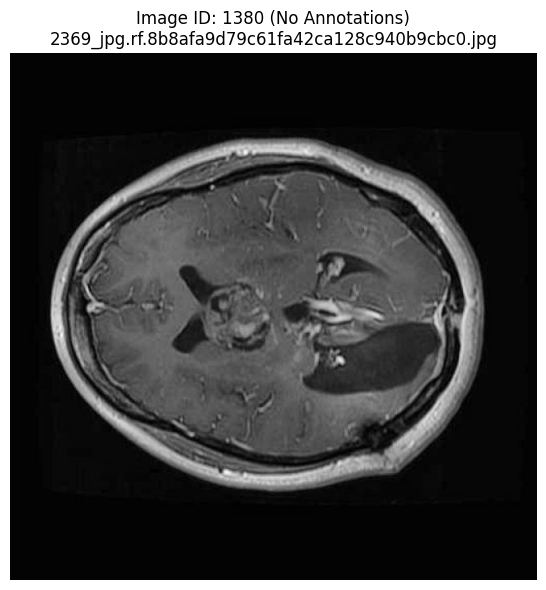

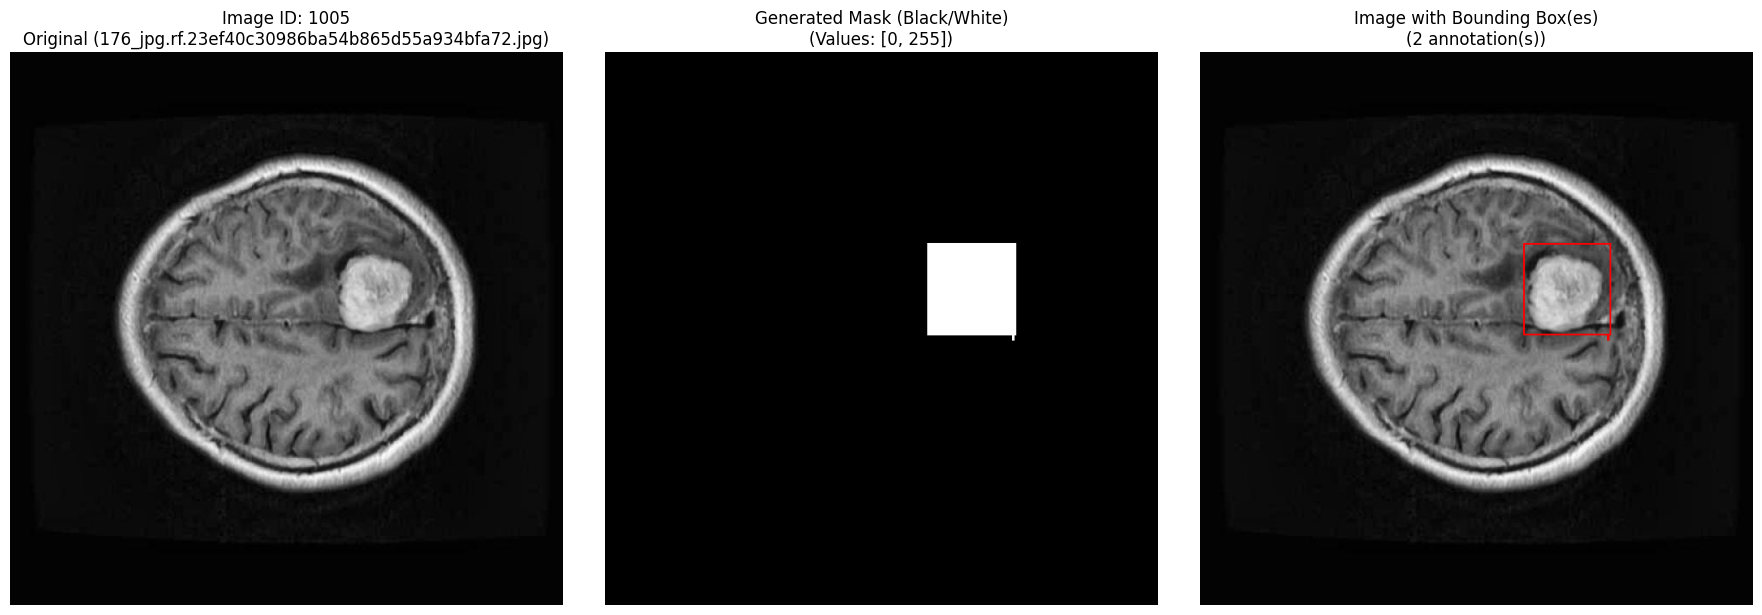

In [21]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# 匯入 PIL (Pillow) 函式庫
try:
    from PIL import Image, ImageDraw
    print("成功匯入 PIL (Pillow)。")
except ImportError:
    print("錯誤：無法匯入 PIL。無法繼續進行圖片處理。")
    raise

# --- 設定 ---
json_path = "./train/_annotations.coco.json" # 從上次成功執行的路徑讀取
image_base_dir = "./train" # 從上次成功執行的路徑讀取
ids_to_display = [1380, 1005] # 指定要顯示的 Image IDs

print(f"--- 程式碼開始 ---")
print(f"將顯示 Image IDs: {ids_to_display}")

try:
    # --- 1. 載入 JSON 檔案 ---
    print(f"正在嘗試載入 JSON 檔案: {json_path}")
    if not os.path.exists(json_path):
        print(f"錯誤：找不到 JSON 檔案 '{json_path}'。")
        raise FileNotFoundError(f"找不到檔案: {json_path}")

    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    print("JSON 檔案載入成功。")

    # --- 2. 建立必要映射 ---
    image_id_to_file = {}
    if 'images' in data:
        for img in data['images']:
            image_id_to_file[img['id']] = img['file_name']

    image_id_to_annotations = defaultdict(list)
    if 'annotations' in data:
        for ann in data['annotations']:
            image_id_to_annotations[ann['image_id']].append(ann)

    # --- 3. 顯示指定的圖片 ---
    for target_id in ids_to_display:
        print(f"\n--- 正在處理 Image ID: {target_id} ---")

        if target_id not in image_id_to_file:
            print(f"錯誤：在 JSON 的 'images' 中找不到 Image ID {target_id} 的紀錄。")
            continue

        file_name = image_id_to_file[target_id]
        image_path = os.path.join(image_base_dir, file_name)

        if not os.path.exists(image_path):
            print(f"錯誤：找不到圖片檔案 {image_path}")
            # 為此 ID 創建一個顯示錯誤的子圖
            fig, ax = plt.subplots(1, 1, figsize=(6, 6))
            ax.set_title(f"Image ID {target_id}\nFile Not Found: {file_name}", color='red')
            ax.axis('off')
            plt.savefig(f"image_{target_id}_error.png")
            print(f"已儲存錯誤訊息圖片至 image_{target_id}_error.png")
            continue

        try:
            # 使用 PIL 載入圖片
            image = Image.open(image_path).convert("RGB")
            annotations = image_id_to_annotations.get(target_id, []) # 使用 .get() 避免 ID 不存在時出錯

            if not annotations:
                # 如果沒有標註 (例如 ID 1380)
                print(f"Image ID {target_id} ({file_name}) 沒有標註。")
                fig, ax = plt.subplots(1, 1, figsize=(6, 6))
                ax.imshow(image)
                ax.set_title(f"Image ID: {target_id} (No Annotations)\n{file_name}")
                ax.axis('off')
                plt.tight_layout()
                plt.savefig(f"image_{target_id}_original.png")
                print(f"已儲存圖片至 image_{target_id}_original.png")
            else:
                # 如果有標註 (例如 ID 1005)
                print(f"Image ID {target_id} ({file_name}) 有 {len(annotations)} 個標註。")
                fig, axes = plt.subplots(1, 3, figsize=(18, 6)) # 顯示原圖、遮罩、邊界框

                # 準備 Mask (使用 PIL)
                mask_pil = Image.new("L", image.size, 0)
                mask_draw = ImageDraw.Draw(mask_pil)

                # 準備 Bounding Box 圖片 (使用 PIL)
                image_with_box = image.copy()
                box_draw = ImageDraw.Draw(image_with_box)

                mask_values = {0}

                for ann in annotations:
                    # 繪製 Bounding Box
                    if 'bbox' in ann:
                        bbox = ann['bbox']
                        x, y, w, h = map(int, bbox)
                        box_draw.rectangle([x, y, x + w, y + h], outline="red", width=2)

                    # 繪製 Segmentation Mask (黑白)
                    if 'segmentation' in ann:
                        segmentation = ann['segmentation']
                        for poly in segmentation:
                            mask_draw.polygon(poly, fill=255)
                        if segmentation:
                            mask_values.add(255)

                # 顯示 - 欄 1: 原始圖片
                ax = axes[0]
                ax.imshow(image)
                ax.set_title(f"Image ID: {target_id}\nOriginal ({file_name})")
                ax.axis('off')

                # 顯示 - 欄 2: 標註 Mask (黑白)
                ax = axes[1]
                ax.imshow(np.array(mask_pil), cmap='gray', vmin=0, vmax=255)
                unique_values = sorted(list(mask_values))
                ax.set_title(f"Generated Mask (Black/White)\n(Values: {unique_values})")
                ax.axis('off')

                # 顯示 - 欄 3: Image with Bounding Box
                ax = axes[2]
                ax.imshow(image_with_box)
                ax.set_title(f"Image with Bounding Box(es)\n({len(annotations)} annotation(s))")
                ax.axis('off')

                plt.tight_layout()
                plt.savefig(f"image_{target_id}_annotated.png")
                print(f"已儲存圖片至 image_{target_id}_annotated.png")

        except Exception as e:
            print(f"處理 Image ID {target_id} 時發生錯誤: {e}")
            # 為此 ID 創建一個顯示錯誤的子圖
            fig, ax = plt.subplots(1, 1, figsize=(6, 6))
            ax.set_title(f"Image ID {target_id}\nError Processing: {e}", color='red')
            ax.axis('off')
            plt.savefig(f"image_{target_id}_error.png")
            print(f"已儲存錯誤訊息圖片至 image_{target_id}_error.png")


except FileNotFoundError:
    print(f"\n程式中止：找不到 '{json_path}'。")
except Exception as e:
    print(f"\n發生未預期的錯誤: {e}")

print("\n--- 程式碼執行完畢 ---")

In [23]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# --- 沿用之前的設定 ---
json_path = "./train/_annotations.coco.json"
image_base_dir = "./train"

print(f"--- 程式碼開始 ---")

try:
    # --- 載入 JSON 檔案 ---
    print(f"正在嘗試載入 JSON 檔案: {json_path}")
    if not os.path.exists(json_path):
        print(f"錯誤：找不到 JSON 檔案 '{json_path}'。")
        raise FileNotFoundError(f"找不到檔案: {json_path}")

    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    print("JSON 檔案載入成功。")

    # --- 記錄原始數量 ---
    original_image_count = len(data.get('images', []))
    original_annotation_count = len(data.get('annotations', []))
    print(f"原始圖片數量: {original_image_count}")
    print(f"原始標註數量: {original_annotation_count}")

    # --- 定義要移除的 ID 列表 ---
    # 這次包含上次的 1380 和這次的 1005
    image_ids_to_remove = {1380, 1005}
    print(f"\n正在移除 Image IDs {list(image_ids_to_remove)} 的紀錄...")

    # --- 移除指定的 Image IDs ---
    removed_image_count_total = 0
    removed_annotation_count_total = 0

    # 篩選 images 列表
    if 'images' in data:
        original_images = data['images']
        # 保留 ID 不在移除列表中的圖片
        data['images'] = [img for img in original_images if img.get('id') not in image_ids_to_remove]
        removed_image_count_total = original_image_count - len(data['images'])
        print(f"- 已從 'images' 移除 {removed_image_count_total} 筆紀錄。")

    # 篩選 annotations 列表
    if 'annotations' in data:
        original_annotations = data['annotations']
         # 保留 image_id 不在移除列表中的標註
        data['annotations'] = [ann for ann in original_annotations if ann.get('image_id') not in image_ids_to_remove]
        removed_annotation_count_total = original_annotation_count - len(data['annotations'])
        print(f"- 已從 'annotations' 移除 {removed_annotation_count_total} 筆紀錄。")

    # --- 記錄處理後數量 ---
    final_image_count = len(data.get('images', []))
    final_annotation_count = len(data.get('annotations', []))
    print(f"\n處理後圖片數量: {final_image_count}")
    print(f"處理後標註數量: {final_annotation_count}")

    # --- 重要提示 ---
    print("\n注意：上述移除操作僅在目前的程式記憶體中生效。")
    print("如果您希望永久保存這個修改，需要將 'data' 變數寫入一個新的 JSON 檔案。")
    # 例如:
    # cleaned_json_path = "./train/_annotations.coco.cleaned.json"
    # with open(cleaned_json_path, 'w', encoding='utf-8') as f:
    #     json.dump(data, f, ensure_ascii=False, indent=4)
    # print(f"已將清理後的資料儲存至 {cleaned_json_path}")


except FileNotFoundError:
    print(f"\n程式中止：找不到 '{json_path}'。")
except Exception as e:
    print(f"\n發生未預期的錯誤: {e}")

print("\n--- 程式碼執行完畢 ---")

--- 程式碼開始 ---
正在嘗試載入 JSON 檔案: ./train/_annotations.coco.json
JSON 檔案載入成功。
原始圖片數量: 1502
原始標註數量: 1502

正在移除 Image IDs [1380, 1005] 的紀錄...
- 已從 'images' 移除 2 筆紀錄。
- 已從 'annotations' 移除 2 筆紀錄。

處理後圖片數量: 1500
處理後標註數量: 1500

注意：上述移除操作僅在目前的程式記憶體中生效。
如果您希望永久保存這個修改，需要將 'data' 變數寫入一個新的 JSON 檔案。

--- 程式碼執行完畢 ---
